In [30]:
# import packages 

import pandas as pd
import numpy as np 


import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from nltk.corpus import stopwords

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import os, glob, sys, re, os, time
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Training Data Cleaning

In [31]:
# read in excel file
reddit = pd.read_excel("Relevant Reddit Posts.xlsx")

In [32]:
reddit.head()

,Text,Subreddit,Title,Author,Location,Created,Link,Theme,Protected Grounds
0,"When I got on the phone with them, they told m...",AskHR,Help!-racist comment said at work-complaint fi...,NaN,NaN,Mar 29 2020,https://www.reddit.com/r/AskHR/comments/frhe4y...,"racist coworker, micro-aggression, HR trouble","Race, Black"
1,I work at a small office. Most of us are clear...,Work,Should I ask HR for diversity training?,NaN,NaN,Oct 04 2018,https://www.reddit.com/r/work/comments/9ldyb5/...,"racist coworker, HR trouble, BLM","Race, Black"
2,Excited to have become the diversity and inclu...,AskHR,Have become diversity and inclusion lead at wo...,NaN,[UK],Jul 24 2020,https://www.reddit.com/r/AskHR/comments/hxaj1y...,"activist action, BLM, mega-threat","Race, Black"
3,Disclaimer I’m not posting this to shame my co...,AskHR,I shadowed a Co worker during a customer faced...,NaN,Houston Texas,Jul 20 2020,https://www.reddit.com/r/AskHR/comments/hkobea...,"HR trouble, racist coworker","Race, Asian, Black"
4,Hello fellow HR people! This is a weird questi...,AskHR,Washington State General Strike,NaN,Washington,Jun 09 2020,https://www.reddit.com/r/AskHR/comments/gzugri...,"activist action, HR trouble, BLM, mega-threat",Race


In [33]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 9 columns):
Text                 94 non-null object
Subreddit            94 non-null object
Title                94 non-null object
Author               71 non-null object
Location             11 non-null object
Created              93 non-null object
Link                 22 non-null object
Theme                93 non-null object
Protected Grounds    92 non-null object
dtypes: object(9)
memory usage: 6.7+ KB


In [34]:
reddit = reddit.rename(columns = {'Subreddit ': 'Subreddit'})

In [35]:
# remove whitespace before any themes after the comma 
reddit['Theme'] = reddit['Theme'].str.replace(", ", ",")

In [36]:
# generate dummies variables from unique values from the theme
topics = reddit['Theme'].str.get_dummies(',')
topics.head(20)

,BLM,HR trouble,activism action,activist action,blm,discrimination,diversity,iscrimination,mega-threat,micro-aggression,racist coworker
0,0,1,0,0,0,0,0,0,0,1,1
1,1,1,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,1
4,1,1,0,1,0,0,0,0,1,0,0
5,1,0,0,1,0,0,0,0,1,0,0
6,1,1,0,1,0,0,0,0,1,0,0
7,1,1,0,0,0,0,0,0,1,0,1
8,1,1,0,1,0,0,0,0,0,1,0
9,1,1,0,0,0,0,0,0,1,0,1


In [37]:
# combine BLM and blm; activism action and activist action columns
topics['BLM'] = topics['BLM'] + topics['blm']

topics['activist action'] = topics['activism action'] + topics['activist action']

topics['discrimination'] = topics['discrimination'] + topics['iscrimination']

topics_clean = topics.drop(columns = ['blm', 'activism action', 'iscrimination'])

topics_clean.head()

,BLM,HR trouble,activist action,discrimination,diversity,mega-threat,micro-aggression,racist coworker
0,0,1,0,0,0,0,1,1
1,1,1,0,0,0,0,0,1
2,1,0,1,0,0,1,0,0
3,0,1,0,0,0,0,0,1
4,1,1,1,0,0,1,0,0


In [38]:
# rename theme values to topic names
topics_clean = topics_clean.rename(columns = {col: 'topic'+'_{}'.format(col) for col in topics.columns}) 

topics_clean.head()

,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker
0,0,1,0,0,0,0,1,1
1,1,1,0,0,0,0,0,1
2,1,0,1,0,0,1,0,0
3,0,1,0,0,0,0,0,1
4,1,1,1,0,0,1,0,0


In [39]:
# now we concate topics_clean back to reddit df 

reddit = reddit.join(topics_clean)
reddit.head()

,Text,Subreddit,Title,Author,Location,Created,Link,Theme,Protected Grounds,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker
0,"When I got on the phone with them, they told m...",AskHR,Help!-racist comment said at work-complaint fi...,NaN,NaN,Mar 29 2020,https://www.reddit.com/r/AskHR/comments/frhe4y...,"racist coworker,micro-aggression,HR trouble","Race, Black",0,1,0,0,0,0,1,1
1,I work at a small office. Most of us are clear...,Work,Should I ask HR for diversity training?,NaN,NaN,Oct 04 2018,https://www.reddit.com/r/work/comments/9ldyb5/...,"racist coworker,HR trouble,BLM","Race, Black",1,1,0,0,0,0,0,1
2,Excited to have become the diversity and inclu...,AskHR,Have become diversity and inclusion lead at wo...,NaN,[UK],Jul 24 2020,https://www.reddit.com/r/AskHR/comments/hxaj1y...,"activist action,BLM,mega-threat","Race, Black",1,0,1,0,0,1,0,0
3,Disclaimer I’m not posting this to shame my co...,AskHR,I shadowed a Co worker during a customer faced...,NaN,Houston Texas,Jul 20 2020,https://www.reddit.com/r/AskHR/comments/hkobea...,"HR trouble,racist coworker","Race, Asian, Black",0,1,0,0,0,0,0,1
4,Hello fellow HR people! This is a weird questi...,AskHR,Washington State General Strike,NaN,Washington,Jun 09 2020,https://www.reddit.com/r/AskHR/comments/gzugri...,"activist action,HR trouble,BLM,mega-threat",Race,1,1,1,0,0,1,0,0


In [40]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
Text                      94 non-null object
Subreddit                 94 non-null object
Title                     94 non-null object
Author                    71 non-null object
Location                  11 non-null object
Created                   93 non-null object
Link                      22 non-null object
Theme                     93 non-null object
Protected Grounds         92 non-null object
topic_BLM                 94 non-null int64
topic_HR trouble          94 non-null int64
topic_activist action     94 non-null int64
topic_discrimination      94 non-null int64
topic_diversity           94 non-null int64
topic_mega-threat         94 non-null int64
topic_micro-aggression    94 non-null int64
topic_racist coworker     94 non-null int64
dtypes: int64(8), object(9)
memory usage: 12.6+ KB


### Text analysis 
- having post text as features using `CountVectorizer`

In [41]:
stop_words = stopwords.words('english')

stop_words.extend(['know', 'make', 'need', 'see', 'say', 'think', 'from', 'subject', 're', 'edu', 'use', 'people', 'going', 'even', 'just', 'still', 'really', 'many', 'thats', 'thing', 'actually', 'one', 'get' ])
stop_words.extend(['subreddit', 'im','dont','have', 'has', 'had', 'are', 'is', 'was', 'were', 'lot', 'lots', 'some', 'can', 'could', 'will', 'would', 'must', 'should', 'also', 'may', 'be'])
stop_words.extend(['question', 'ask','discuss','redditor', 'reddit', 'post','dedicate', 'discussion'])
vect_act = CountVectorizer(lowercase=False, min_df=50, max_df=0.6)


In [42]:
# removes numbers from text
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    return text

vect_text = CountVectorizer(min_df=3, max_df=0.9, ngram_range=(1, 3), stop_words=stop_words, 
                            preprocessor=preprocess_text)

In [43]:
text = reddit.Text
text_dtm = vect_text.fit_transform(text)
df_text = pd.DataFrame(text_dtm.toarray())
n_text=len(df_text. columns)+1
dict(zip(list(range(n_text)), vect_text.get_feature_names()))
df_text.rename(columns=dict(zip(list(range(n_text)), vect_text.get_feature_names())), inplace=True)


In [44]:
other = reddit[list(topics_clean.columns)]

In [45]:
DF = pd.concat([reddit['Subreddit'], other, df_text], axis=1)
DF.head()

,Subreddit,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker,As,...,world,worth,write,wrong,year,years,yes,yet,younger,youâ
0,AskHR,0,1,0,0,0,0,1,1,0,...,0,0,1,1,0,0,5,0,0,0
1,Work,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,AskHR,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AskHR,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,AskHR,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Topic_BLM

In [46]:
X = df_text
y = other['topic_BLM']

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# we don't have stratify parameter is because The stratify parameter set it to split data in a way to allocate 
# test_size amount of data to each class. In this case, you don't have sufficient class labels of one of your classes 
# to keep the data splitting ratio equal to test_size.

#### SVM model


CPU times: user 13.1 ms, sys: 332 µs, total: 13.5 ms
Wall time: 14.4 ms
Accuracy: 62.07%
              precision    recall  f1-score   support

           0       0.63      0.94      0.76        18
           1       0.50      0.09      0.15        11

   micro avg       0.62      0.62      0.62        29
   macro avg       0.56      0.52      0.45        29
weighted avg       0.58      0.62      0.53        29



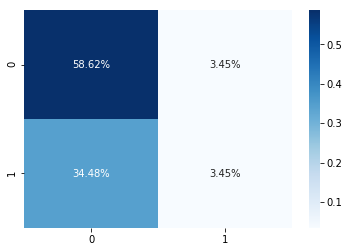

In [47]:
# import and instantiate a SVM model
from sklearn.svm import SVC

model = SVC(C=1, kernel='linear', probability=True )

model.fit(X_train, y_train)
%time model.fit(X_train, y_train)

# make predictions for test data
#%time y_pred = model.predict(X_test)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

#### Random Forests

CPU times: user 561 ms, sys: 277 ms, total: 838 ms
Wall time: 746 ms
CPU times: user 69.2 ms, sys: 14.8 ms, total: 84.1 ms
Wall time: 107 ms
Accuracy: 65.52%
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        18
           1       1.00      0.09      0.17        11

   micro avg       0.66      0.66      0.66        29
   macro avg       0.82      0.55      0.47        29
weighted avg       0.78      0.66      0.55        29



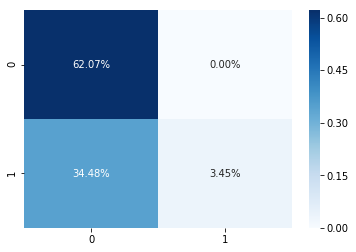

In [48]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators= 500, n_jobs=-1, max_depth=5, random_state=8, class_weight='balanced')

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
cm=metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
cm
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

#### Multinomial Naive Bayes Model


CPU times: user 4.22 ms, sys: 4.93 ms, total: 9.15 ms
Wall time: 24 ms
CPU times: user 3.56 ms, sys: 254 µs, total: 3.82 ms
Wall time: 1.99 ms
Accuracy: 72.41%
              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.71      0.45      0.56        11

   micro avg       0.72      0.72      0.72        29
   macro avg       0.72      0.67      0.68        29
weighted avg       0.72      0.72      0.71        29



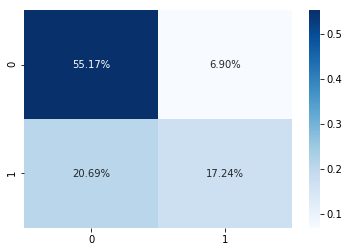

In [49]:
# fit a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha = 1)
%time model.fit(X_train, y_train)

# make predictions for test data
%time y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

#### Conclusion
It seems that MultinomialNB model does a better job at predicting posts that are BLM related; both in terms of accuracy measures and precision and recall measures. 